In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# This converts the images (0-255) into Tensors (0.0 - 1.0)
transform = transforms.Compose([transforms.ToTensor()])

# Download and load training data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a loader to feed data in batches of 64 images at a time
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.17MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 269kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.71MB/s]


In [14]:
from torch import nn, Tensor
import torch.nn.functional as F
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # Layer 1: Takes 784 inputs, transforms to 128 hidden features
        # Math: Hidden = (Input * Weights1) + Bias1
        self.fc1 = nn.Linear(28 * 28, 128)
        
        # Layer 2: Takes 128 hidden features, transforms to 64 hidden features the out because there are 10 classes 1-10
        # Math: Hidden2 = (Hidden1 * Weights2) + Bias2
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x: Tensor) -> Tensor:
        # Flatten the 28x28 images into 784 element vectors
        x = x.view(-1, 28 * 28)
        
        # Apply first layer and ReLU activation
        x = F.relu(self.fc1(x))
        
        # Apply second layer
        x = self.fc2(x)
        
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SimpleNet().to(device=device)
print(model)
        

Using device: cuda
SimpleNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
import torch.optim as optim

# CrossEntropyLoss is standard for classification (choosing 1 out of N categories)
criterion = nn.CrossEntropyLoss()

# Stochastic Gradient Descent (SGD) with a learning rate of 0.01
# It tweaks the weights slightly in the opposite direction of the error
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [15]:
# We will loop through the entire dataset 5 times
# Re-running the training loop with CUDA
epochs = 5
print("Training on:", device)

for epoch in range(epochs):
    running_loss = 0.0
    
    for images, labels in train_loader:
        # --- THE IMPORTANT PART ---
        # Move inputs and labels to the GPU
        images, labels = images.to(device), labels.to(device)
        # --------------------------

        optimizer.zero_grad()
        
        outputs = model(images)           # Model is already on GPU
        loss = criterion(outputs, labels) # Calculates loss on GPU
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}")

print("Training Finished!")

Training on: cuda
Epoch 1 - Loss: 2.2874
Epoch 2 - Loss: 2.2874
Epoch 3 - Loss: 2.2874
Epoch 4 - Loss: 2.2874
Epoch 5 - Loss: 2.2874
Training Finished!


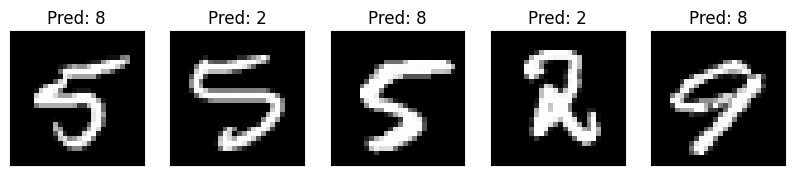

In [19]:
import matplotlib.pyplot as plt

# Get a batch of images
images, labels = next(iter(train_loader))

# Get predictions
with torch.no_grad(): # Tell PyTorch we don't need gradients for this (saves memory)
    images = images.to(device)  # Move images to the same device as the model
    outputs = model(images)
    # The prediction is the index with the highest score
    _, predicted = torch.max(outputs, 1)

# Show the first 5 images and their predictions
fig = plt.figure(figsize=(10, 2))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    # Convert tensor image back to numpy for display
    # .cpu() moves it back to system memory
    img = images[i].cpu().squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {predicted[i].item()}")
plt.show()
